# Challenge 6: Classification Error Metric Challenges

| Title        | Answer                     |
| :---------- | :------------------------ |
| Topic:       | Classification Errors | 
| Date:        | 2016/07/31                 |
| Name:        | Michelle L. Gill           |
| Worked with: | None                       | 




In [79]:
import pandas as pd
import numpy as np
import cPickle as pickle

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

%matplotlib inline

## Question 1

For the house representatives data set, calculate the accuracy, precision, recall and f1 scores of each classifier you built (on the test set).

In [80]:
votes = pd.read_pickle('../../05-classification/michelle/votes.pkl')  
knn   = pd.read_pickle('../../05-classification/michelle/knn_house.mdl')
log   = pd.read_pickle('../../05-classification/michelle/log_house.mdl')
tree  = pd.read_pickle('../../05-classification/michelle/decisiontreeclassifier_house.mdl')
nb    = pd.read_pickle('../../05-classification/michelle/gaussiannb_house.mdl')
rf    = pd.read_pickle('../../05-classification/michelle/randomforestclassifier_house.mdl')
svc   = pd.read_pickle('../../05-classification/michelle/svc_house.mdl')

In [81]:
def recode(arr):
    return [1 if x=='republican' else 0 for x in arr]

train, test = train_test_split(votes, test_size=0.3, random_state=4444)
vote_cols = ['v{}'.format(x) for x in range(1,17)]

# train['party'] = recode(train['party'])
# test['party'] = recode(test['party'])

merit_list = list()

for model,name in zip([log, knn, tree, nb, rf[0], svc],
                      ['Logistic','KNN','DecisionTree',
                       'NaiveBayes','RandomForest',
                       'SVM']):

    Ytest = test['party'].astype(np.object)
    Ytest = recode(Ytest)
    
    Ypred = model.predict(test[vote_cols])
    Ypred = recode(Ypred)
    
    try:
        Ypred_plot = model.decision_function(test[vote_cols])
    except:
        Ypred_plot = model.predict_proba(test[vote_cols])[:,1]
    
    accuracy = accuracy_score(Ytest, Ypred)
    precision = precision_score(Ytest, Ypred)
    recall = recall_score(Ytest, Ypred)
    f1 = f1_score(Ytest, Ypred)
    auc = roc_auc_score(Ytest, Ypred)

    #xdata, ydata, _ = roc_curve(Ytest, Ypred)
    xdata, ydata, _ = roc_curve(Ytest, Ypred_plot)

    df = pd.Series({'data':name, 
                    'f1': f1, 
                    'accuracy':accuracy, 'auc':auc,
                    'precision':precision, 'recall':recall,
                    'roc_x': xdata, 'roc_y': ydata})
    
    merit_list.append(df)

In [82]:
merit_df = pd.concat(merit_list, axis=1).T
merit_df[['data','f1','accuracy','precision','recall']]

,data,f1,accuracy,precision,recall
0,Logistic,0.923077,0.938931,0.96,0.888889
1,KNN,0.915888,0.931298,0.924528,0.907407
2,DecisionTree,0.924528,0.938931,0.942308,0.907407
3,NaiveBayes,0.932039,0.946565,0.979592,0.888889
4,RandomForest,0.921569,0.938931,0.979167,0.87037
5,SVM,0.953271,0.961832,0.962264,0.944444


## Question 2
For each, draw the ROC curve and calculate the AUC.

*AUC is calculated above*

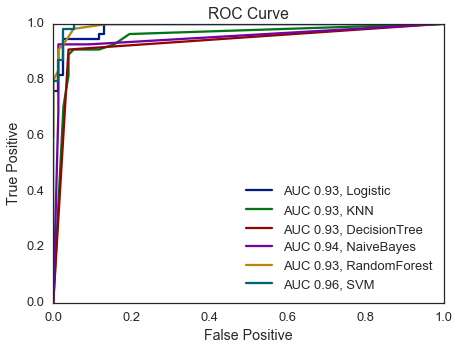

In [83]:
f = plt.figure()
f.set_size_inches(7,5)
ax = plt.axes()

for idx,dat in merit_df.iterrows():
    name = dat['data']
    auc = dat['auc']
    xdata = dat.roc_x
    ydata = dat.roc_y
    ax.plot(xdata,ydata,label='AUC {:.2f}, {}'.format(auc,name))
    
ax.legend(loc=0)
_ = ax.set(xlabel='False Positive',ylabel='True Positive',title='ROC Curve')

## Question 3
Calculate the same metrics you did in challenge 1, but this time in a cross validation scheme with the cross_val_score function (like in Challenge 9).

In [84]:
cv_list = list()

for model,name in zip([log, knn, tree, nb, rf[0], svc],
                      ['Logistic','KNN','DecisionTree',
                       'NaiveBayes','RandomForest',
                       'SVM']):

    accuracy = cross_val_score(model, train[vote_cols], train['party'], scoring='accuracy').mean()
    precision = cross_val_score(model, train[vote_cols], recode(train['party']), scoring='precision').mean()
    recall = cross_val_score(model, train[vote_cols], recode(train['party']), scoring='recall').mean()
    f1 = cross_val_score(model, train[vote_cols], recode(train['party']), scoring='f1').mean()
    
    df = pd.Series({'label':name, 'accuracy':accuracy, 'precision':precision,
                    'recall':recall, 'f1':f1})
    cv_list.append(df)

In [85]:
pd.concat(cv_list, axis=1).T[['label','accuracy','f1','precision','recall']]

,label,accuracy,f1,precision,recall
0,Logistic,0.957257,0.94196,0.955364,0.929825
1,KNN,0.924513,0.902954,0.869919,0.938596
2,DecisionTree,0.93422,0.926287,0.905514,0.947368
3,NaiveBayes,0.927781,0.905308,0.890351,0.921053
4,RandomForest,0.93752,0.914718,0.932732,0.95614
5,SVM,0.960655,0.950161,0.921531,0.982456


## Question 4
For your movie classifiers, calculate the precision and recall for each class.

In [86]:
movies = pd.read_csv('../../../challenges_data/2013_movies.csv').dropna()

feat_cols = ['Budget', 'DomesticTotalGross', 'Runtime']
movies[feat_cols] = Normalizer().fit_transform(movies[feat_cols])

mtrain, mtest = train_test_split(movies, test_size=0.3, random_state=4444)
Ytest = mtest['Rating']

#LR = pd.read_pickle('../../05-classification/michelle/log_movie.mdl')
#KNN = pd.read_pickle('../../05-classification/michelle/knn_movie.mdl')

In [87]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Logistic multiclass
LR = OneVsRestClassifier(LogisticRegression())
LR.fit(mtrain[feat_cols], mtrain['Rating'])

Ypred = LR.predict(mtest[feat_cols])

pr_list = list()
df = pd.Series({'name':'Logistic', 
                'precision':precision_score(Ytest, Ypred), 
                'recall':recall_score(Ytest, Ypred)})

pr_list.append(df)


# KNN
KNN = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
KNN.fit(mtrain[feat_cols], mtrain['Rating'])

Ypred = KNN.predict(mtest[feat_cols])

df = pd.Series({'name':'KNN', 'precision':precision_score(Ytest, Ypred), 
                'recall':recall_score(Ytest, Ypred)})

pr_list.append(df)

/Volumes/Files/miniconda/envs/scienv2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Volumes/Files/miniconda/envs/scienv2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_we

In [88]:
pd.concat(pr_list, axis=1).T

,name,precision,recall
0,Logistic,0.281433,0.333333
1,KNN,0.391738,0.481481


## Question 5
Draw the ROC curve (and calculate AUC) for the logistic regression classifier from challenge 12.

In [90]:
with open('../../05-classification/michelle/LR_haberman.pkl','r') as fh:
    LR = pickle.load(fh)
    
train = pd.read_pickle('../../05-classification/michelle/haberman_train.pkl')
test = pd.read_pickle('../../05-classification/michelle/haberman_test.pkl')

train['survival'] -= 1
test['survival'] -= 1


Ytest = test['survival']
Ypred = LR.predict(test[['age_op','year_op','num_nodes']])
Ypred_plot = LR.predict_proba(test[['age_op','year_op','num_nodes']])[:,1]

auc = roc_auc_score(Ytest, Ypred_plot)

xdata, ydata, _ = roc_curve(Ytest, Ypred_plot)

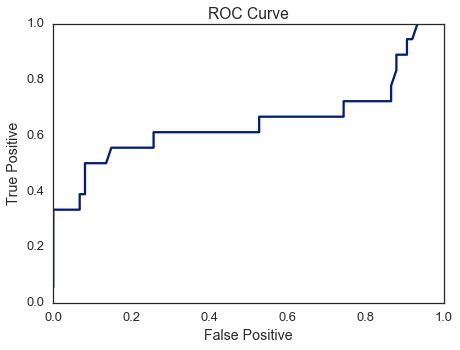

In [91]:
f = plt.figure()
f.set_size_inches(7, 5)
ax = plt.axes()

ax.plot(xdata, ydata)
    
ax.legend(loc=0)
_ = ax.set(xlabel='False Positive', 
           ylabel='True Positive', 
           title='ROC Curve')